In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Understanding Simple RNN Fundamentals

### What is a Simple RNN?

A Simple RNN (Recurrent Neural Network) is the most basic form of recurrent neural network that can process sequences of data by maintaining a "memory" of previous inputs.

Key Characteristics:

- Sequential Processing: Processes data one time step at a time

- Memory: Maintains hidden state that carries information from previous time steps

- Parameter Sharing: Uses the same weights across all time steps

- Suitable for: Short sequences (5-10 time steps) due to vanishing gradient problem



### Simple RNN Architecture


In [ ]:
# Basic Simple RNN structure
# Input: [batch_size, sequence_length, features]
# Hidden State: [batch_size, hidden_units]
# Output: [batch_size, output_units]

## Code Implementation

### Change Working directory

In [ ]:
import os
os.chdir('/content/drive/MyDrive/DAM202')
os.listdir()

['egypt_real_estate_listings.csv',
 'text.txt',
 'Practical2(DAM202).ipynb',
 'IMDB_cleaned.csv',
 'weather_data.csv',
 'best_simple_rnn_model.h5',
 'IMDB_custom_cleaned.csv',
 'fasttext_model.model.wv.vectors_ngrams.npy',
 'fasttext_model.model']

### 1.1 Installation and Imports

In [ ]:
#Install required packages (run in terminal)
!pip install tensorflow pandas numpy matplotlib scikit-learn seaborn

In [ ]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for Simple RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

# Data preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Setup completed successfully!")


TensorFlow version: 2.19.0
Setup completed successfully!


### 1.2 Data Loading and Exploration

#### 1.2.1  Load Bangladesh Weather Data

In [ ]:
def load_weather_data(file_path):
    """
    Load Bangladesh weather data and create proper structure

    Expected CSV format:
    Year, Day, Wind_Speed, Specific_Humidity, Relative_Humidity, Precipitation, Temperature
    Example: 1990, 240, 3.26, 15.62, 65, 0.69, 30.65
    """

    # Load the CSV file
    df = pd.read_csv('weather_data.csv') #Same working directory

    # Define column names based on your data description
    column_names = [
        'Year', 'Day', 'Wind_Speed', 'Specific_Humidity',
        'Relative_Humidity', 'Precipitation', 'Temperature'
    ]

    # Assign column names if they're not already set
    if len(df.columns) == len(column_names):
        df.columns = column_names

    # Create proper date from Year and Day
    df['Date'] = pd.to_datetime(df['Year'] * 1000 + df['Day'], format='%Y%j')

    # Set date as index for time series analysis
    df.set_index('Date', inplace=True)

    # Remove original Year and Day columns
    df.drop(['Year', 'Day'], axis=1, inplace=True)

    print(f"Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    return df

# Load your data
data_file = "bangladesh_weather_data.csv"  # Replace with your file path
df = load_weather_data(data_file)


Data loaded successfully!
Shape: (12113, 5)
Date range: 1990-01-01 00:00:00 to 2023-03-01 00:00:00


In [ ]:
df.head()

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature
Date,,,,,
1990-01-01,1.08,5.68,53.06,0.0,16.33
1990-01-02,1.13,5.92,58.06,0.0,15.68
1990-01-03,1.33,5.68,52.69,0.0,16.56
1990-01-04,1.09,5.19,47.19,0.0,17.09
1990-01-05,0.94,4.82,42.88,0.0,17.26


In [ ]:
#Compare with original dataset
main_df = pd.read_csv('weather_data.csv') #Same working directory
main_df.head()

,Year,Day,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature
0,1990,1,1.08,5.68,53.06,0.0,16.33
1,1990,2,1.13,5.92,58.06,0.0,15.68
2,1990,3,1.33,5.68,52.69,0.0,16.56
3,1990,4,1.09,5.19,47.19,0.0,17.09
4,1990,5,0.94,4.82,42.88,0.0,17.26


#### 1.2.2 Data Exploration and Visualization

=== BANGLADESH WEATHER DATA EXPLORATION ===
Dataset Shape: (12113, 5)
Date Range: 1990-01-01 to 2023-03-01
Total Days: 12113 days
Years Covered: 34 years

=== BASIC STATISTICS ===
       Wind_Speed  Specific_Humidity  Relative_Humidity  Precipitation  \
count    12113.00           12113.00           12113.00       12113.00   
mean         1.31              15.21              74.64           7.18   
std          0.54               5.53              15.29          13.13   
min          0.44               2.62              15.81           0.00   
25%          0.95               9.95              65.25           0.00   
50%          1.15              16.17              79.62           1.16   
75%          1.52              20.57              86.56           9.26   
max          5.34              24.29              96.12         170.63   

       Temperature  
count     12113.00  
mean         25.04  
std           4.37  
min          11.19  
25%          21.43  
50%          26.93  
75%   

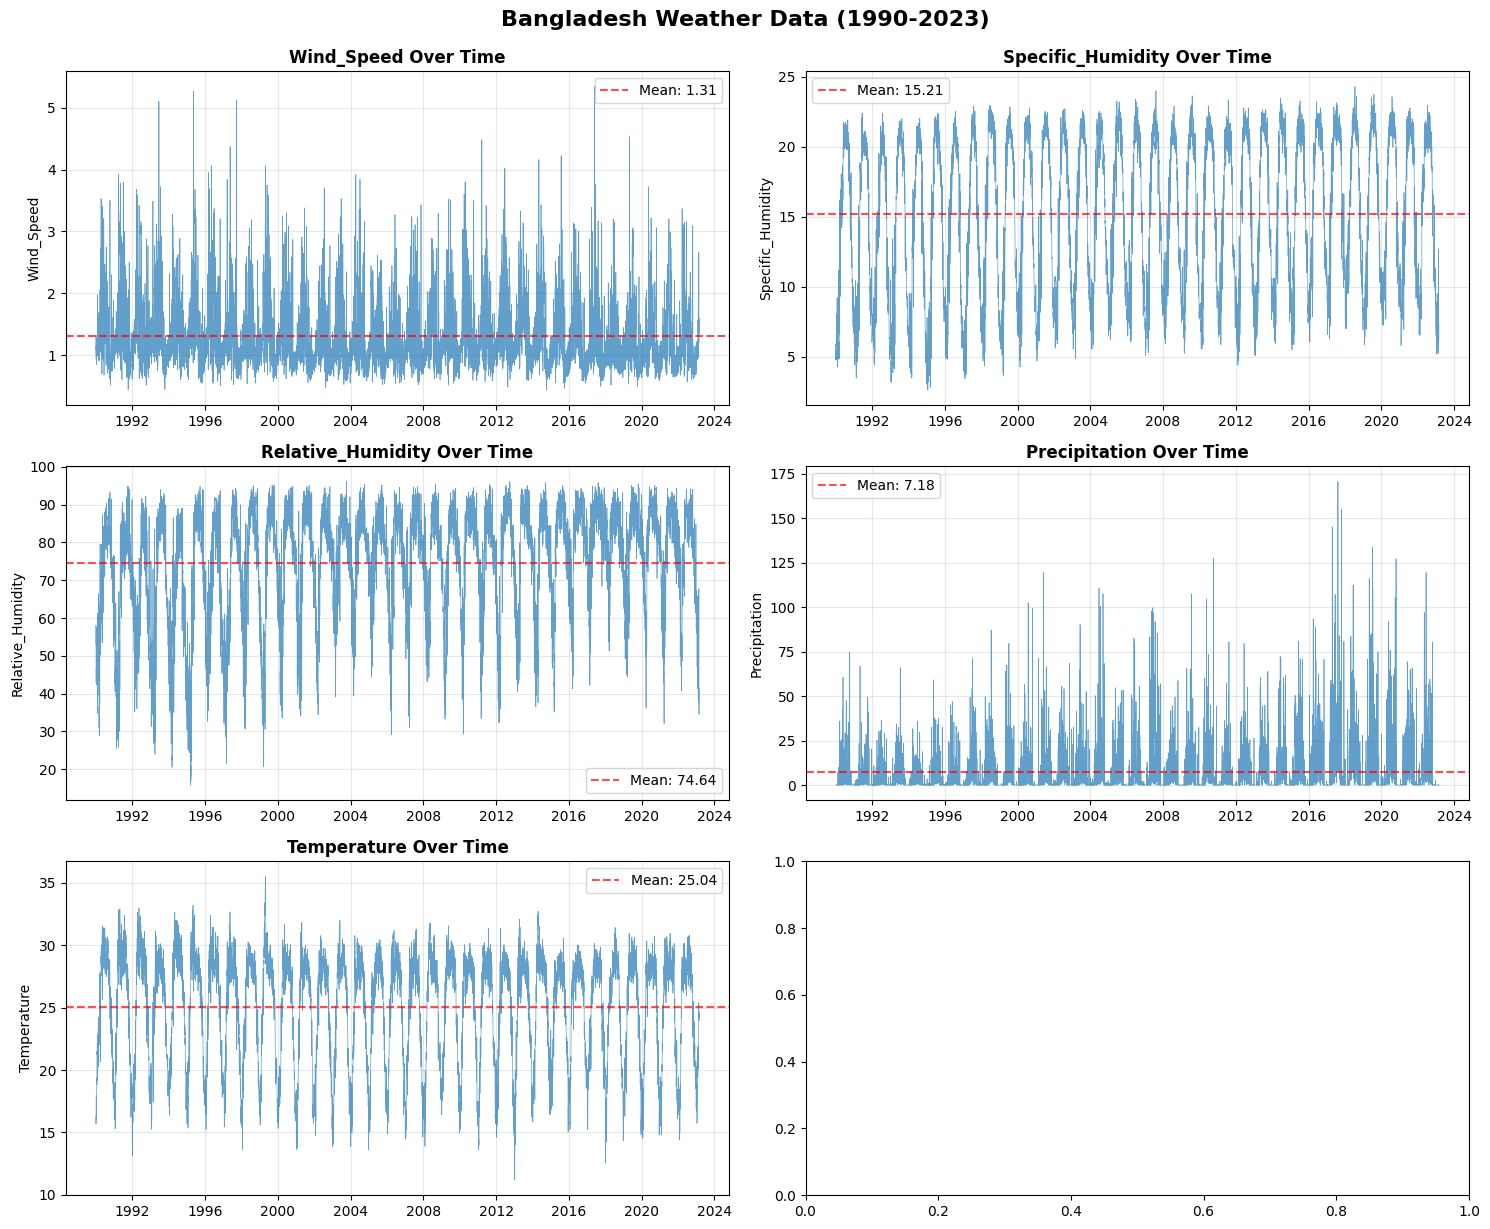

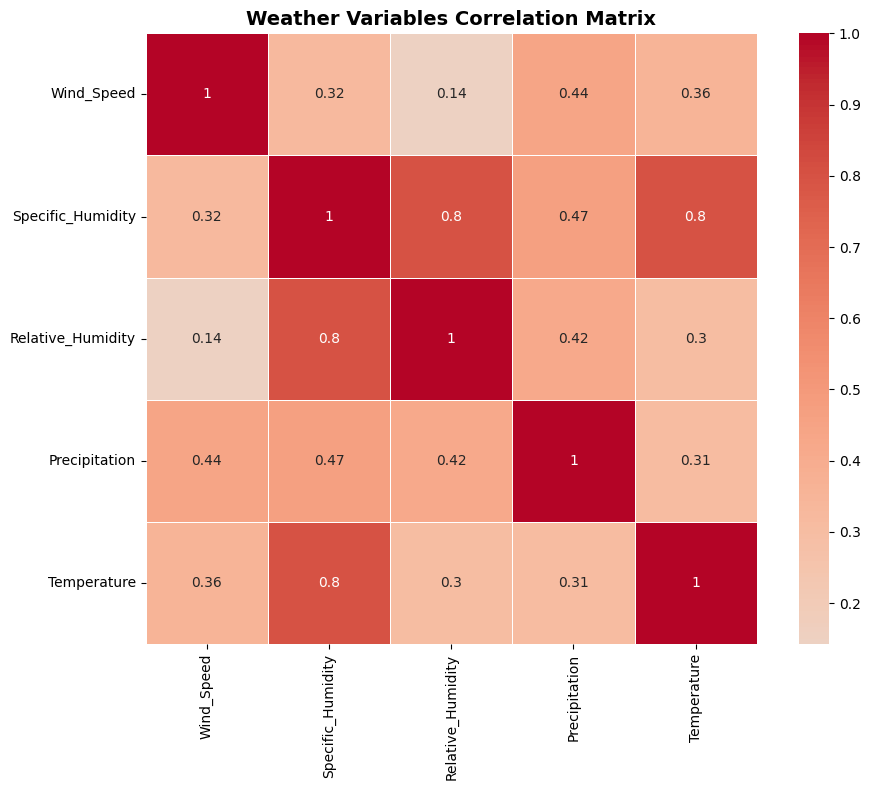

In [ ]:
def explore_weather_data(df):
    """
    Comprehensive exploration of weather data
    """

    print("=== BANGLADESH WEATHER DATA EXPLORATION ===")
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Total Days: {len(df)} days")
    print(f"Years Covered: {df.index.year.nunique()} years")

    # Basic statistics
    print("\n=== BASIC STATISTICS ===")
    print(df.describe().round(2))

    # Check for missing values
    print("\n=== MISSING VALUES ===")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Data types
    print("\n=== DATA TYPES ===")
    print(df.dtypes)

    # Visualize all weather variables
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column], alpha=0.7, linewidth=0.5)
        axes[i].set_title(f'{column} Over Time', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(column)
        axes[i].grid(True, alpha=0.3)

        # Add some statistics to the plot
        mean_val = df[column].mean()
        axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7,
                       label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

    plt.tight_layout()
    plt.suptitle('Bangladesh Weather Data (1990-2023)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Weather Variables Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return df

# Explore the data
df_explored = explore_weather_data(df)


### 1.3 Data Preprocessing for Simple RNN

#### 1.3.1 Data Cleaning

In [ ]:
def clean_weather_data(df):
    """
    Clean the weather data for Simple RNN processing
    """

    print("=== DATA CLEANING PROCESS ===")

    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    # 1. Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Forward fill then backward fill for time series data
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

    print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

    # 2. Remove outliers using IQR method
    print("\n=== OUTLIER REMOVAL ===")

    for column in df_clean.columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers_before = ((df_clean[column] < lower_bound) |
                          (df_clean[column] > upper_bound)).sum()

        # Remove outliers by clipping
        df_clean[column] = df_clean[column].clip(lower=lower_bound, upper=upper_bound)

        print(f"{column}: {outliers_before} outliers handled")

    # 3. Basic feature engineering for time series
    df_clean['Month'] = df_clean.index.month
    df_clean['Day_of_Year'] = df_clean.index.dayofyear

    # Add simple moving averages (helpful for Simple RNN)
    df_clean['Temp_MA_3'] = df_clean['Temperature'].rolling(window=3).mean()
    df_clean['Temp_MA_7'] = df_clean['Temperature'].rolling(window=7).mean()

    # Remove rows with NaN values created by moving averages
    df_clean.dropna(inplace=True)

    print(f"\nFinal dataset shape: {df_clean.shape}")

    return df_clean

# Clean the data
df_clean = clean_weather_data(df_explored)

=== DATA CLEANING PROCESS ===
Missing values before cleaning: 0
Missing values after cleaning: 0

=== OUTLIER REMOVAL ===
Wind_Speed: 661 outliers handled
Specific_Humidity: 0 outliers handled
Relative_Humidity: 152 outliers handled
Precipitation: 1089 outliers handled
Temperature: 0 outliers handled

Final dataset shape: (12107, 9)


/tmp/ipython-input-601555160.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')


In [ ]:
df_clean.head()

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857
1990-01-09,0.85,4.82,42.31,0.0,17.25,1,9,17.603333,17.287143
1990-01-10,1.14,4.76,45.38,0.0,16.33,1,10,17.053333,17.254286
1990-01-11,1.07,5.07,48.44,0.0,16.15,1,11,16.576667,17.120000


#### 1.3.2 Data Normalization (Critical for Simple RNN)


In [ ]:
def normalize_data_for_rnn(df, target_column='Temperature'):
    """
    Normalize data for Simple RNN training

    Important: We fit the scaler only on training data to prevent data leakage
    """

    print(f"=== DATA NORMALIZATION FOR SIMPLE RNN ===")
    print(f"Target variable: {target_column}")

    # Separate features and target
    feature_columns = [col for col in df.columns if col != target_column]

    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")

    # Initialize scalers
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    return df, feature_columns, feature_scaler, target_scaler

# Prepare for normalization
df_processed, feature_columns, feature_scaler, target_scaler = normalize_data_for_rnn(df_clean)

=== DATA NORMALIZATION FOR SIMPLE RNN ===
Target variable: Temperature
Feature columns: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Number of features: 8


In [ ]:
df_processed.head(2)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857


In [ ]:
# --- EXERCISE 3: FEATURE SELECTION ---
# Here you can modify the feature_columns list to experiment.
#
# To try different combinations, you can comment or uncomment lines.
# For example, to train only on temperature-related features and humidity:
#
print("Original features:", feature_columns)

# --- Try your new combination here ---
feature_columns = [
    'Relative_Humidity', # Keep
    'Specific_Humidity', # Keep
    'Wind_Speed',        # Remove
    'Precipitation',     # Remove based on what to observe
    'Month',             # Keep for seasonality
    'Day_of_Year',       # Keep for seasonality
    'Temp_MA_3',         # Keep moving average
    'Temp_MA_7',         # Keep moving average
]

print("New features for training:", feature_columns)

Original features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
New features for training: ['Relative_Humidity', 'Specific_Humidity', 'Wind_Speed', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']


These lines are for basic feature engineering in time series analysis, which helps a neural network learn patterns better by adding informative features derived from the raw data.

What are these features?
- Month: The month from each date (e.g., January, February, etc.), which helps encode potential seasonal effects (like monsoons or cold seasons).

- Day_of_Year: The position of each date in the year (e.g., 1 for January 1st, 365 for December 31st), which can capture cyclic trends and annual seasonality.

- Temp_MA_3: The average temperature over the past 3 days for each day.

- Temp_MA_7: The average temperature over the past 7 days for each day.

Why are they done?
- Month and Day_of_Year transform raw date information into numerical features so that machine learning models can learn from seasonal patterns (e.g., temperature might be higher in June than in December).

- Moving averages (Temp_MA_3 and Temp_MA_7) smooth the original temperature signal. They reduce noise and short-term fluctuations, making longer-term trends and cycles more visible for the model. These features help the neural network understand not just today's temperature but also recent context, which is important for forecasting.

Why do we do this for time series models?
- Expose Patterns: Weather data shows seasonal/cyclic behaviors; encoding month and day-of-year helps the model pick up on regular patterns.

- Reduce Noise: Moving averages help to “smooth out” outlier values, giving the model a clearer picture of underlying trends.

Learning Context: RNNs thrive when they can access recent history. Including moving averages lets the model access summarized context of the recent past, not just raw daily values

#### 1.3.3 Time Series Train-Test Split

In [ ]:
def create_time_series_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create time-aware train/validation/test split for time series

    Important: No shuffling to maintain temporal order!
    """

    print(f"=== TIME SERIES DATA SPLITTING ===")

    n_samples = len(df)

    # Calculate split indices
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))

    # Split data maintaining temporal order
    train_data = df.iloc[:train_end].copy()
    val_data = df.iloc[train_end:val_end].copy()
    test_data = df.iloc[val_end:].copy()

    print(f"Training data: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
    print(f"Validation data: {len(val_data)} samples ({val_data.index.min()} to {val_data.index.max()})")
    print(f"Test data: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")

    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = create_time_series_split(df_processed)

=== TIME SERIES DATA SPLITTING ===
Training data: 8474 samples (1990-01-07 00:00:00 to 2013-03-20 00:00:00)
Validation data: 1816 samples (2013-03-21 00:00:00 to 2018-03-10 00:00:00)
Test data: 1817 samples (2018-03-11 00:00:00 to 2023-03-01 00:00:00)


In [ ]:
train_data.head(2)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857


### 1.4 Creating Sequences for Simple RNN

#### Understanding Sequence Creation
Simple RNNs work best with shorter sequences (5-7 days) due to the vanishing gradient problem. Here's how we create sequences:



In [ ]:
def create_sequences_for_simple_rnn(features, target, sequence_length=5):
    """
    Create sequences for Simple RNN training

    For Simple RNN, we use shorter sequences (5-7 days) for better performance

    Parameters:
    - data: scaled data array
    - target_column: index of target column
    - sequence_length: number of time steps to look back (keep it short for Simple RNN)
    """

    sequences = []
    targets = []

    # Create sequences
    for i in range(sequence_length, len(features)):
        # Get sequence of past 'sequence_length' days
        sequences.append(features[i-sequence_length:i])  # Shape: (sequence_length, features)

        # Get target (next day's temperature)
        targets.append(target[i])  # Single value

    return np.array(sequences), np.array(targets)


In [ ]:
def prepare_data_for_simple_rnn(train_data, val_data, test_data,
                               feature_columns, target_column,
                               feature_scaler, target_scaler,
                               sequence_length=5):
    """
    Complete data preparation pipeline for Simple RNN
    """

    print(f"=== PREPARING DATA FOR SIMPLE RNN ===")
    print(f"Sequence length: {sequence_length} days")
    print(f"Target: {target_column}")
    print(f"Features: {feature_columns}")

    # 1. Scale the data (fit only on training data!)
    train_features_scaled = feature_scaler.fit_transform(train_data[feature_columns])
    train_target_scaled = target_scaler.fit_transform(train_data[[target_column]])
    print(f"Train Target : {train_target_scaled.flatten().shape}")

    val_features_scaled = feature_scaler.transform(val_data[feature_columns])
    val_target_scaled = target_scaler.transform(val_data[[target_column]])

    test_features_scaled = feature_scaler.transform(test_data[feature_columns])
    test_target_scaled = target_scaler.transform(test_data[[target_column]])

    # 2. Combine features and target for sequence creation
    train_combined = np.column_stack([train_features_scaled, train_target_scaled])
    val_combined = np.column_stack([val_features_scaled, val_target_scaled])
    test_combined = np.column_stack([test_features_scaled, test_target_scaled])

    # 3. Find target column index in combined array
    #target_idx = train_data.columns.get_loc('Temperature')

    # 4. Create sequences
    X_train, y_train = create_sequences_for_simple_rnn(train_features_scaled, train_target_scaled.flatten(), sequence_length)
    X_val, y_val = create_sequences_for_simple_rnn(val_features_scaled, val_target_scaled.flatten(), sequence_length)
    X_test, y_test = create_sequences_for_simple_rnn(test_features_scaled, test_target_scaled.flatten(), sequence_length)


    print(f"Training sequences: {X_train.shape}")
    print(f"Training targets: {y_train.shape}")
    print(f"Validation sequences: {X_val.shape}")
    print(f"Test sequences: {X_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Prepare sequences (using short sequence length for Simple RNN)
SEQUENCE_LENGTH = 5  # Only 5 days - optimal for Simple RNN

(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data_for_simple_rnn(
    train_data, val_data, test_data,
    feature_columns, 'Temperature',
    feature_scaler, target_scaler,
    sequence_length=SEQUENCE_LENGTH
)

print("Data preparation completed successfully!")

=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 5 days
Target: Temperature
Features: ['Relative_Humidity', 'Specific_Humidity', 'Wind_Speed', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8469, 5, 8)
Training targets: (8469,)
Validation sequences: (1811, 5, 8)
Test sequences: (1812, 5, 8)
Data preparation completed successfully!


In [ ]:
X_train[100]

array([[0.48388637, 0.59709874, 0.53506494, 0.04406048, 0.27272727,
        0.29041096, 0.74475574, 0.72374025],
       [0.50473462, 0.60832943, 1.        , 0.15809935, 0.27272727,
        0.29315068, 0.74292552, 0.73180001],
       [0.49980107, 0.59709874, 1.        , 0.21900648, 0.27272727,
        0.29589041, 0.73363368, 0.7322587 ],
       [0.65401448, 0.68834815, 1.        , 0.81382289, 0.27272727,
        0.29863014, 0.71913276, 0.72564052],
       [0.73645261, 0.72297613, 1.        , 1.        , 0.27272727,
        0.30136986, 0.69815571, 0.71993972]])

### 1.5 Building Simple RNN Model

#### 1.5.1 Understanding Simple RNN Architecture

In [ ]:
def create_simple_rnn_model(input_shape, hidden_units=32, dropout_rate=0.2):
    """
    Create a Simple RNN model optimized for weather prediction

    Architecture:
    1. SimpleRNN layer with specified hidden units
    2. Dropout for regularization
    3. Dense layer for final prediction

    Parameters:
    - input_shape: (sequence_length, number_of_features)
    - hidden_units: number of neurons in RNN layer
    - dropout_rate: dropout rate for regularization
    """

    print(f"=== BUILDING SIMPLE RNN MODEL ===")
    print(f"Input shape: {input_shape}")
    print(f"Hidden units: {hidden_units}")
    print(f"Dropout rate: {dropout_rate}")

    model = Sequential(name="Simple_RNN_Weather_Predictor")

    # Add Input layer to specify input shape
    model.add(Input(shape=input_shape, name='Input_Layer'))

    # Add SimpleRNN layer without input_shape argument
    model.add(SimpleRNN(
        units=hidden_units,
        activation='tanh',  # Default activation
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        name='SimpleRNN_Layer'
    ))


    # Add dropout for additional regularization
    model.add(Dropout(dropout_rate, name='Dropout_Layer'))

    # Add dense layer for final prediction
    model.add(Dense(
        units=1,
        activation='linear',  # Linear activation for regression
        name='Output_Layer'
    ))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
    )

    # Display model summary
    print("\n=== MODEL ARCHITECTURE ===")
    model.summary()

    return model

# Create the Simple RNN model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
model = create_simple_rnn_model(input_shape, hidden_units=32, dropout_rate=0.2)

=== BUILDING SIMPLE RNN MODEL ===
Input shape: (5, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

#### 1.5.2 Model Training Strategy

In [ ]:
def train_simple_rnn_model(model, X_train, y_train, X_val, y_val,
                          epochs=100, batch_size=32, patience=10):
    """
    Train Simple RNN model with proper callbacks

    Simple RNN training considerations:
    - Lower epochs (50) due to faster convergence
    - Early stopping to prevent overfitting
    - Learning rate reduction for better convergence
    """

    print(f"=== TRAINING SIMPLE RNN MODEL ===")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ModelCheckpoint(
            'best_simple_rnn_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    print("\nStarting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
        shuffle=False  # Important: Don't shuffle time series data
    )

    print("Training completed!")
    return history

# Train the model
training_history = train_simple_rnn_model(
    model, X_train, y_train, X_val, y_val,
    epochs=100, batch_size=32, patience=10
)


=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8469
Validation samples: 1811
Epochs: 100
Batch size: 32

Starting training...
Epoch 1/100
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1355 - mean_absolute_error: 0.2853 - mean_absolute_percentage_error: 55.0138
Epoch 1: val_loss improved from inf to 0.00569, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1334 - mean_absolute_error: 0.2829 - mean_absolute_percentage_error: 722.6583 - val_loss: 0.0057 - val_mean_absolute_error: 0.0575 - val_mean_absolute_percentage_error: 11.8931
Epoch 2/100
245/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0415 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 31.1379
Epoch 2: val_loss improved from 0.00569 to 0.00540, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0411 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 756.0372 - val_loss: 0.0054 - val_mean_absolute_error: 0.0568 - val_mean_absolute_percentage_error: 13.6159
Epoch 3/100
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - mean_absolute_error: 0.1308 - mean_absolute_percentage_error: 26.1962
Epoch 3: val_loss did not improve from 0.00540
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0270 - mean_absolute_error: 0.1307 - mean_absolute_percentage_error: 553.3339 - val_loss: 0.0056 - val_mean_absolute_error: 0.0578 - val_mean_absolute_percentage_error: 13.7205
Epoch 4/100
257/265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 - mean_absolute_error: 0.1202 - mean_absolute_percentage_error: 24.3081
Epoch 4: val_loss did not improve from 0.00540
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0227 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 783.2254 - val_loss: 0.0056 - val_mean_absolute_er

265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0173 - mean_absolute_error: 0.1048 - mean_absolute_percentage_error: 706.3484 - val_loss: 0.0054 - val_mean_absolute_error: 0.0544 - val_mean_absolute_percentage_error: 13.8486
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Training completed!


### 1.6 Model Evaluation and Visualization

#### 1.6.1 Training History Visualization

=== TRAINING HISTORY VISUALIZATION ===


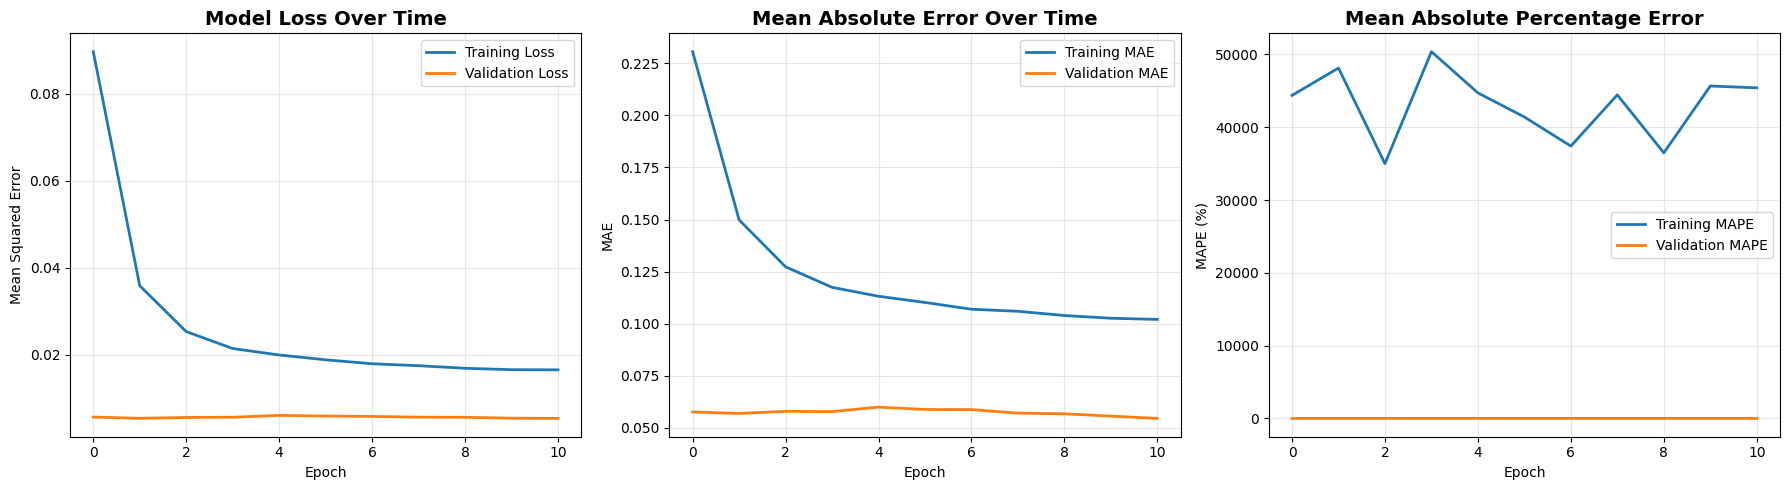

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Visualize training history for Simple RNN
    """

    print("=== TRAINING HISTORY VISUALIZATION ===")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mean_absolute_error'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Mean Absolute Error Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # MAPE plot
    axes[2].plot(history.history['mean_absolute_percentage_error'],
                label='Training MAPE', linewidth=2)
    axes[2].plot(history.history['val_mean_absolute_percentage_error'],
                label='Validation MAPE', linewidth=2)
    axes[2].set_title('Mean Absolute Percentage Error', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('MAPE (%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history)

#### 1.6.2 Model Performance Evaluation

In [ ]:
def evaluate_simple_rnn_performance(model, X_test, y_test, target_scaler, ):
    """
    Comprehensive evaluation of Simple RNN performance
    """

    print("=== SIMPLE RNN MODEL EVALUATION ===")

    # Make predictions
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Inverse transform to original scale
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled).flatten()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # Calculate MAPE manually
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    # Temperature-specific accuracy (within certain degrees)
    accuracy_1deg = np.mean(np.abs(y_test_original - y_pred_original) <= 1.0) * 100
    accuracy_2deg = np.mean(np.abs(y_test_original - y_pred_original) <= 2.0) * 100
    accuracy_3deg = np.mean(np.abs(y_test_original - y_pred_original) <= 3.0) * 100

    # Print results
    print("\n🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️")
    print("=" * 55)
    print(f"📊 Mean Squared Error (MSE):      {mse:.4f}")
    print(f"📊 Root Mean Squared Error (RMSE): {rmse:.4f}°C")
    print(f"📊 Mean Absolute Error (MAE):     {mae:.4f}°C")
    print(f"📊 R-squared Score (R²):          {r2:.4f}")
    print(f"📊 Mean Absolute Percentage Error: {mape:.2f}%")
    print("=" * 55)
    print("🎯 TEMPERATURE PREDICTION ACCURACY:")
    print(f"   Within ±1°C: {accuracy_1deg:.1f}% of predictions")
    print(f"   Within ±2°C: {accuracy_2deg:.1f}% of predictions")
    print(f"   Within ±3°C: {accuracy_3deg:.1f}% of predictions")
    print("=" * 55)

    return {
        'y_true': y_test_original,
        'y_pred': y_pred_original,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'accuracy_1deg': accuracy_1deg,
        'accuracy_2deg': accuracy_2deg,
        'accuracy_3deg': accuracy_3deg
    }

# Evaluate the model
evaluation_results = evaluate_simple_rnn_performance(model, X_test, y_test, target_scaler)

=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      3.3008
📊 Root Mean Squared Error (RMSE): 1.8168°C
📊 Mean Absolute Error (MAE):     1.4107°C
📊 R-squared Score (R²):          0.8233
📊 Mean Absolute Percentage Error: 5.94%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 45.5% of predictions
   Within ±2°C: 75.1% of predictions
   Within ±3°C: 90.1% of predictions


#### 1.6.3 Prediction Visualization

=== PREDICTION VISUALIZATION ===


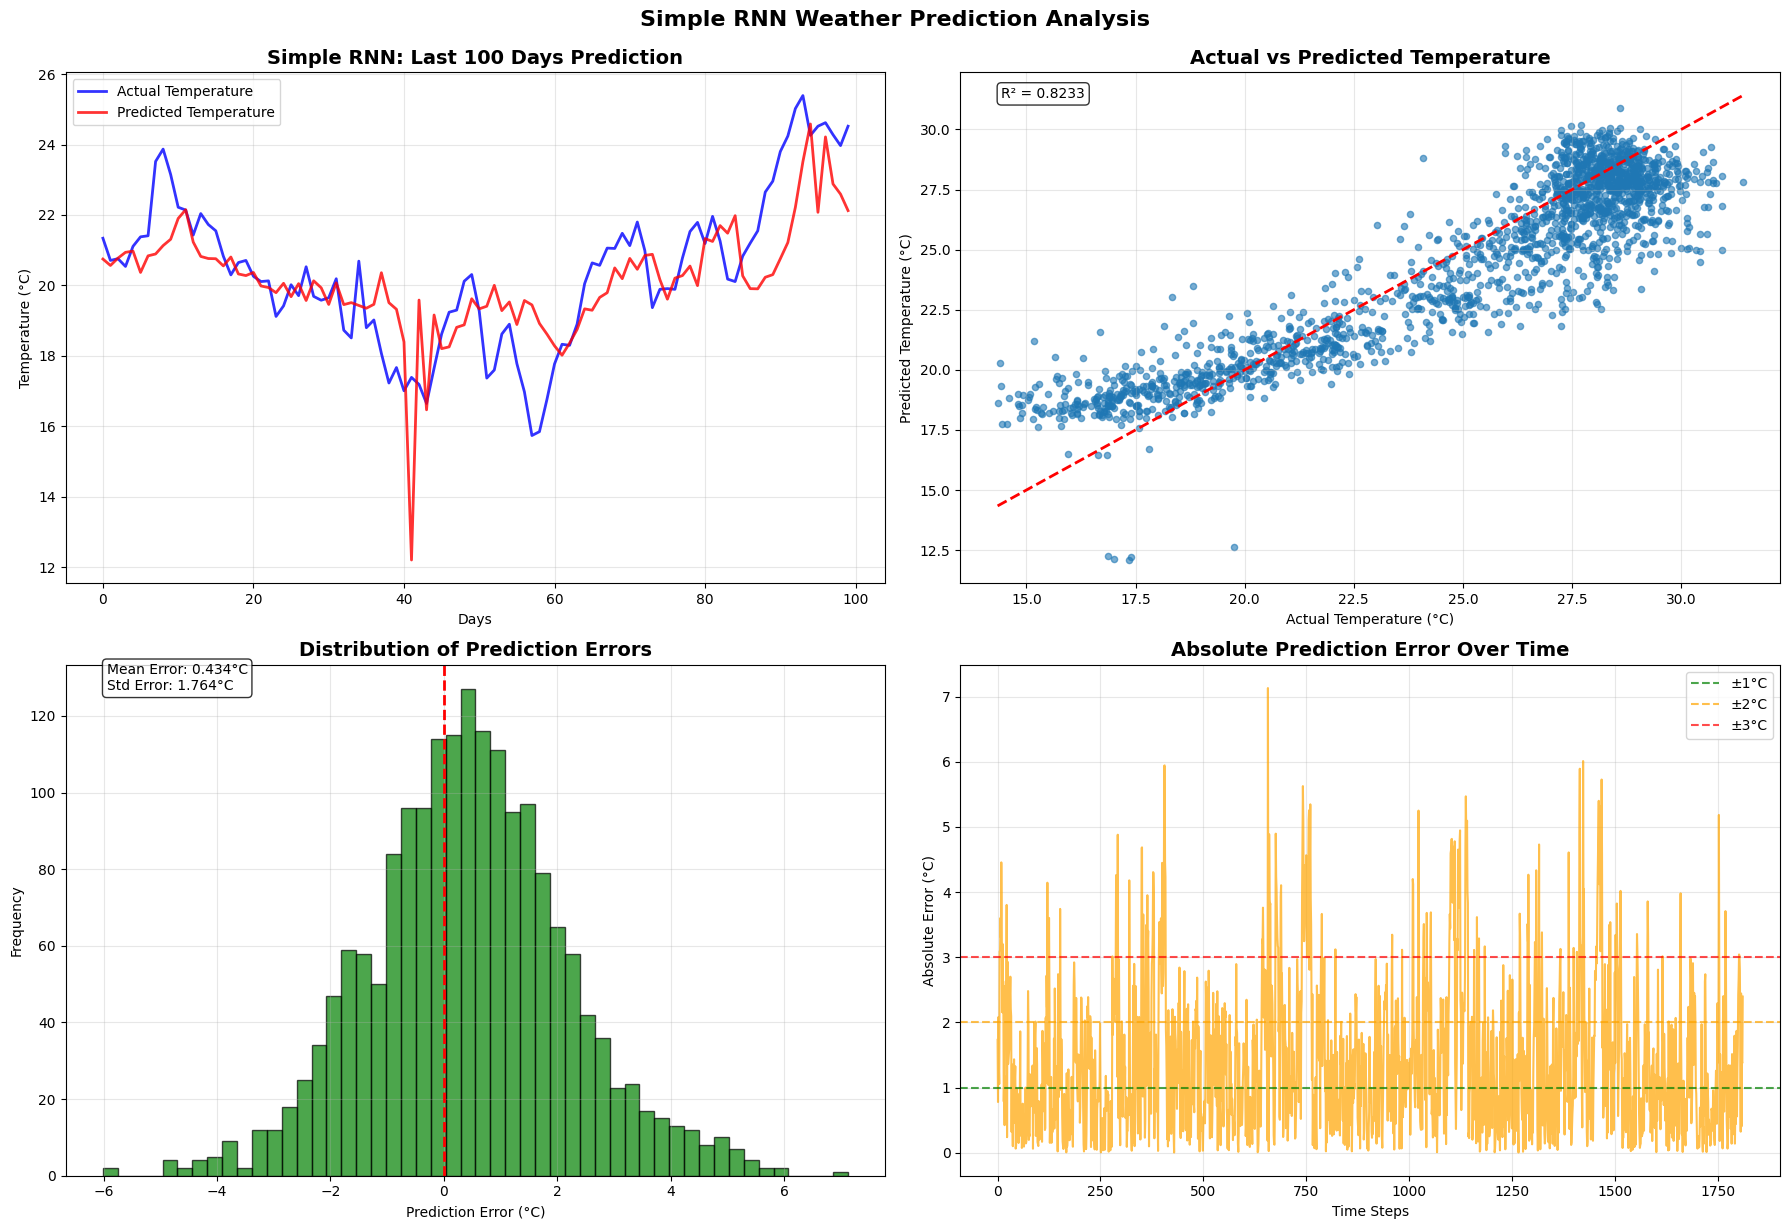

In [ ]:
def visualize_predictions(results, days_to_show=100):
    """
    Create comprehensive visualizations of Simple RNN predictions
    """

    print(f"=== PREDICTION VISUALIZATION ===")

    y_true = results['y_true']
    y_pred = results['y_pred']

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Time series plot (last N days)
    axes[0, 0].plot(y_true[-days_to_show:], label='Actual Temperature',
                   linewidth=2, alpha=0.8, color='blue')
    axes[0, 0].plot(y_pred[-days_to_show:], label='Predicted Temperature',
                   linewidth=2, alpha=0.8, color='red')
    axes[0, 0].set_title(f'Simple RNN: Last {days_to_show} Days Prediction',
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Scatter plot: Actual vs Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, s=20)
    min_temp, max_temp = y_true.min(), y_true.max()
    axes[0, 1].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Temperature (°C)')
    axes[0, 1].set_ylabel('Predicted Temperature (°C)')
    axes[0, 1].set_title('Actual vs Predicted Temperature', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Add R² to scatter plot
    r2 = results['r2']
    axes[0, 1].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 3. Error distribution
    errors = y_true - y_pred
    axes[1, 0].hist(errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Prediction Error (°C)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Add error statistics
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    axes[1, 0].text(0.05, 0.95, f'Mean Error: {mean_error:.3f}°C\nStd Error: {std_error:.3f}°C',
                   transform=axes[1, 0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 4. Error over time
    axes[1, 1].plot(np.abs(errors), alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Time Steps')
    axes[1, 1].set_ylabel('Absolute Error (°C)')
    axes[1, 1].set_title('Absolute Prediction Error Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # Add horizontal lines for accuracy thresholds
    axes[1, 1].axhline(1, color='green', linestyle='--', alpha=0.7, label='±1°C')
    axes[1, 1].axhline(2, color='orange', linestyle='--', alpha=0.7, label='±2°C')
    axes[1, 1].axhline(3, color='red', linestyle='--', alpha=0.7, label='±3°C')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.suptitle('Simple RNN Weather Prediction Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Visualize predictions
visualize_predictions(evaluation_results, days_to_show=100)


#### 1.6.4 Real-time Prediction Function

In [ ]:
def make_weather_prediction(model, recent_data, feature_scaler, target_scaler,
                           feature_columns, sequence_length=5):
    """
    Make a weather prediction using the trained Simple RNN model

    Parameters:
    - model: trained Simple RNN model
    - recent_data: pandas DataFrame with recent weather data (last 'sequence_length' days)
    - feature_scaler: fitted feature scaler
    - target_scaler: fitted target scaler
    - feature_columns: list of feature column names
    - sequence_length: number of days to use for prediction
    """

    print(f"=== MAKING NEW WEATHER PREDICTION ===")

    if len(recent_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} days of recent data")

    # Get the last sequence_length days
    recent_sequence = recent_data[feature_columns].iloc[-sequence_length-1:-1].values

    # Scale the data
    #recent_sequence_scaled = feature_scaler.transform(recent_sequence)

    #Convert recent_sequence (numpy array) back to DataFrame with columns for scaler
    recent_sequence_df = pd.DataFrame(recent_sequence, columns=feature_columns)
    print(recent_sequence_df)


    # Now transform with feature scaler (which expects column names)
    recent_sequence_scaled = feature_scaler.transform(recent_sequence_df)

    # Reshape for model input: (1, sequence_length, features)
    input_sequence = recent_sequence_scaled.reshape(1, sequence_length, -1)

    # Make prediction (scaled)
    prediction_scaled = model.predict(input_sequence, verbose=0)

    # Inverse transform to get actual temperature
    predicted_temp = target_scaler.inverse_transform(prediction_scaled)[0, 0]

    print(f"🌡️  Predicted temperature for tomorrow: {predicted_temp:.2f}°C")

    return predicted_temp

# Example: Make prediction using last 5 days of test data
sample_recent_data = test_data.iloc[-10:]  # Last 10 days as example
prediction = make_weather_prediction(
    model, sample_recent_data, feature_scaler, target_scaler,
    feature_columns, sequence_length=SEQUENCE_LENGTH
)


=== MAKING NEW WEATHER PREDICTION ===
   Relative_Humidity  Specific_Humidity  Wind_Speed  Precipitation  Month  \
0              67.75              12.15        1.20           0.37    2.0   
1              50.44               8.85        1.28           0.00    2.0   
2              38.06               6.59        1.41           0.00    2.0   
3              34.56               6.04        1.60           0.00    2.0   
4              38.94               6.65        1.49           0.00    2.0   

   Day_of_Year  Temp_MA_3  Temp_MA_7  
0         55.0  24.890000  24.045714  
1         56.0  24.723333  24.312857  
2         57.0  24.466667  24.550000  
3         58.0  24.473333  24.618571  
4         59.0  24.290000  24.580000  
🌡️  Predicted temperature for tomorrow: 22.12°C


In [ ]:
df_clean.tail(5)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
2023-02-25,1.28,8.85,50.44,0.0,24.52,2,56,24.723333,24.312857
2023-02-26,1.41,6.59,38.06,0.0,24.62,2,57,24.466667,24.550000
2023-02-27,1.60,6.04,34.56,0.0,24.28,2,58,24.473333,24.618571
2023-02-28,1.49,6.65,38.94,0.0,23.97,2,59,24.290000,24.580000
2023-03-01,1.36,7.39,41.38,0.0,24.52,3,60,24.256667,24.508571


In [ ]:
print(f"Actual Temperture value of last data: {df_clean.tail(5)['Temperature'].values[-1]}")

Actual Temperture value of last data: 24.52


### Understanding Simple RNN Limitations

In [ ]:
def analyze_simple_rnn_limitations():
    """
    Educational analysis of Simple RNN limitations for students
    """

    print("=== UNDERSTANDING SIMPLE RNN LIMITATIONS ===")
    print("\n🧠 WHY SIMPLE RNN HAS LIMITATIONS:")
    print("=" * 50)

    print("1. 📉 VANISHING GRADIENT PROBLEM:")
    print("   - Gradients become very small as they propagate back through time")
    print("   - Model struggles to learn from events more than 5-10 time steps ago")
    print("   - Weather patterns often require longer memory (weeks/months)")

    print("\n2. 🔄 SHORT-TERM MEMORY:")
    print("   - Simple RNN forgets information from distant past quickly")
    print("   - Weather has seasonal patterns that need long-term memory")
    print("   - Best performance with 3-7 day sequences")

    print("\n3. 🎯 PERFORMANCE COMPARISON:")
    print("   - Simple RNN: Good for short-term patterns")
    print("   - LSTM/GRU: Better for long-term dependencies")
    print("   - Complex weather patterns need advanced models")

    print("\n💡 WHEN TO USE SIMPLE RNN:")
    print("   ✅ Learning RNN fundamentals")
    print("   ✅ Short-term predictions (1-3 days)")
    print("   ✅ Simple patterns and trends")
    print("   ✅ Computational resource constraints")
    print("   ✅ Proof of concept projects")

    print("\n🚀 NEXT STEPS FOR STUDENTS:")
    print("   1. Master Simple RNN concepts")
    print("   2. Learn LSTM architecture")
    print("   3. Compare performance differences")
    print("   4. Understand when to use each model")
    print("=" * 50)

# Run the educational analysis
analyze_simple_rnn_limitations()

=== UNDERSTANDING SIMPLE RNN LIMITATIONS ===

🧠 WHY SIMPLE RNN HAS LIMITATIONS:
1. 📉 VANISHING GRADIENT PROBLEM:
   - Gradients become very small as they propagate back through time
   - Model struggles to learn from events more than 5-10 time steps ago
   - Weather patterns often require longer memory (weeks/months)

2. 🔄 SHORT-TERM MEMORY:
   - Simple RNN forgets information from distant past quickly
   - Weather has seasonal patterns that need long-term memory
   - Best performance with 3-7 day sequences

3. 🎯 PERFORMANCE COMPARISON:
   - Simple RNN: Good for short-term patterns
   - LSTM/GRU: Better for long-term dependencies
   - Complex weather patterns need advanced models

💡 WHEN TO USE SIMPLE RNN:
   ✅ Learning RNN fundamentals
   ✅ Short-term predictions (1-3 days)
   ✅ Simple patterns and trends
   ✅ Computational resource constraints
   ✅ Proof of concept projects

🚀 NEXT STEPS FOR STUDENTS:
   1. Master Simple RNN concepts
   2. Learn LSTM architecture
   3. Compare perfor

### Student Exercises

In [ ]:
def student_exercises():
    """
    Hands-on exercises for students to reinforce learning
    """

    print("📚 STUDENT EXERCISES - SIMPLE RNN WEATHER PREDICTION")
    print("=" * 60)

    exercises = [
        {
            "title": "Exercise 1: Experiment with Sequence Length",
            "description": "Try different sequence lengths (3, 5, 7, 10) and observe performance changes",
            "code_hint": "modify sequence_length parameter in prepare_data_for_simple_rnn()",
            "expected_outcome": "Understand how sequence length affects Simple RNN performance"
        },
        {
            "title": "Exercise 2: Change Hidden Units",
            "description": "Test different hidden layer sizes (16, 32, 64, 128)",
            "code_hint": "modify hidden_units parameter in create_simple_rnn_model()",
            "expected_outcome": "Learn about model capacity and overfitting"
        },
        {
            "title": "Exercise 3: Feature Selection",
            "description": "Try using different combinations of weather features",
            "code_hint": "modify feature_columns list before training",
            "expected_outcome": "Understand which features are most important for prediction"
        },
        {
            "title": "Exercise 4: Predict Different Variables",
            "description": "Try predicting humidity or wind speed instead of temperature",
            "code_hint": "change target_column parameter to 'Relative_Humidity' or 'Wind_Speed'",
            "expected_outcome": "See how model performs on different weather variables"
        },
        {
            "title": "Exercise 5: Error Analysis",
            "description": "Identify when the model makes the largest errors",
            "code_hint": "analyze prediction errors by season or weather conditions",
            "expected_outcome": "Understand model limitations and failure cases"
        }
    ]

    for i, exercise in enumerate(exercises, 1):
        print(f"\n🎯 {exercise['title']}")
        print(f"   📝 Task: {exercise['description']}")
        print(f"   💡 Hint: {exercise['code_hint']}")
        print(f"   🎯 Goal: {exercise['expected_outcome']}")

    print("\n" + "=" * 60)
    print("💡 Remember: Simple RNN is a stepping stone to advanced models!")

# Display exercises
student_exercises()


📚 STUDENT EXERCISES - SIMPLE RNN WEATHER PREDICTION

🎯 Exercise 1: Experiment with Sequence Length
   📝 Task: Try different sequence lengths (3, 5, 7, 10) and observe performance changes
   💡 Hint: modify sequence_length parameter in prepare_data_for_simple_rnn()
   🎯 Goal: Understand how sequence length affects Simple RNN performance

🎯 Exercise 2: Change Hidden Units
   📝 Task: Test different hidden layer sizes (16, 32, 64, 128)
   💡 Hint: modify hidden_units parameter in create_simple_rnn_model()
   🎯 Goal: Learn about model capacity and overfitting

🎯 Exercise 3: Feature Selection
   📝 Task: Try using different combinations of weather features
   💡 Hint: modify feature_columns list before training
   🎯 Goal: Understand which features are most important for prediction

🎯 Exercise 4: Predict Different Variables
   📝 Task: Try predicting humidity or wind speed instead of temperature
   💡 Hint: change target_column parameter to 'Relative_Humidity' or 'Wind_Speed'
   🎯 Goal: See how mod

=== Starting Experiment: Impact of Sequence Length on RNN Performance ===
\n--- Testing Sequence Length: 3 ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 3 days
Target: Temperature
Features: ['Relative_Humidity', 'Specific_Humidity', 'Wind_Speed', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8471, 3, 8)
Training targets: (8471,)
Validation sequences: (1813, 3, 8)
Test sequences: (1814, 3, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (3, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8471
Validation samples: 1813
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
238/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1662 - mean_absolute_error: 0.3141 - mean_absolute_percentage_error: 59.8450
Epoch 1: val_loss improved from inf to 0.00661, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1600 - mean_absolute_error: 0.3074 - mean_absolute_percentage_error: 751.9725 - val_loss: 0.0066 - val_mean_absolute_error: 0.0653 - val_mean_absolute_percentage_error: 14.7902
Epoch 2/50
234/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 32.6863
Epoch 2: val_loss improved from 0.00661 to 0.00529, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0457 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 747.8527 - val_loss: 0.0053 - val_mean_absolute_error: 0.0564 - val_mean_absolute_percentage_error: 13.3132
Epoch 3/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - mean_absolute_error: 0.1410 - mean_absolute_percentage_error: 28.1684
Epoch 3: val_loss did not improve from 0.00529
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0319 - mean_absolute_error: 0.1409 - mean_absolute_percentage_error: 695.6475 - val_loss: 0.0057 - val_mean_absolute_error: 0.0584 - val_mean_absolute_percentage_error: 14.0657
Epoch 4/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0263 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 26.2589
Epoch 4: val_loss did not improve from 0.00529
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 649.9454 - val_loss: 0.0061 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8469
Validation samples: 1811
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1865 - mean_absolute_error: 0.3341 - mean_absolute_percentage_error: 156.9814
Epoch 1: val_loss improved from inf to 0.00610, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1862 - mean_absolute_error: 0.3339 - mean_absolute_percentage_error: 187.2360 - val_loss: 0.0061 - val_mean_absolute_error: 0.0603 - val_mean_absolute_percentage_error: 13.9180
Epoch 2/50
258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0504 - mean_absolute_error: 0.1776 - mean_absolute_percentage_error: 34.5369
Epoch 2: val_loss did not improve from 0.00610
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0502 - mean_absolute_error: 0.1772 - mean_absolute_percentage_error: 471.7684 - val_loss: 0.0062 - val_mean_absolute_error: 0.0599 - val_mean_absolute_percentage_error: 14.0857
Epoch 3/50
263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - mean_absolute_error: 0.1426 - mean_absolute_percentage_error: 134.4698
Epoch 3: val_loss improved from 0.00610 to 0.00534, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0325 - mean_absolute_error: 0.1425 - mean_absolute_percentage_error: 446.3944 - val_loss: 0.0053 - val_mean_absolute_error: 0.0557 - val_mean_absolute_percentage_error: 13.5598
Epoch 4/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 25.4873
Epoch 4: val_loss did not improve from 0.00534
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 608.7138 - val_loss: 0.0054 - val_mean_absolute_error: 0.0569 - val_mean_absolute_percentage_error: 13.4920
Epoch 5/50
249/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.1201 - mean_absolute_percentage_error: 24.4323
Epoch 5: val_loss did not improve from 0.00534
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0227 - mean_absolute_error: 0.1199 - mean_absolute_percentage_error: 630.8548 - val_loss: 0.0057 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8467
Validation samples: 1809
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
252/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2904 - mean_absolute_error: 0.4137 - mean_absolute_percentage_error: 80.4300
Epoch 1: val_loss improved from inf to 0.00706, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2844 - mean_absolute_error: 0.4089 - mean_absolute_percentage_error: 900.5317 - val_loss: 0.0071 - val_mean_absolute_error: 0.0660 - val_mean_absolute_percentage_error: 13.6548
Epoch 2/50
244/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0674 - mean_absolute_error: 0.2043 - mean_absolute_percentage_error: 38.6019
Epoch 2: val_loss improved from 0.00706 to 0.00511, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0665 - mean_absolute_error: 0.2028 - mean_absolute_percentage_error: 815.9472 - val_loss: 0.0051 - val_mean_absolute_error: 0.0558 - val_mean_absolute_percentage_error: 12.7474
Epoch 3/50
255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 30.7306
Epoch 3: val_loss did not improve from 0.00511
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0391 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 718.5464 - val_loss: 0.0053 - val_mean_absolute_error: 0.0565 - val_mean_absolute_percentage_error: 13.4887
Epoch 4/50
250/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mean_absolute_error: 0.1314 - mean_absolute_percentage_error: 26.4064
Epoch 4: val_loss did not improve from 0.00511
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - mean_absolute_error: 0.1313 - mean_absolute_percentage_error: 619.3109 - val_loss: 0.0059 - val_mean_absolute_erro

Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8464
Validation samples: 1806
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
247/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1780 - mean_absolute_error: 0.3309 - mean_absolute_percentage_error: 64.9341
Epoch 1: val_loss improved from inf to 0.00555, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1737 - mean_absolute_error: 0.3265 - mean_absolute_percentage_error: 187.0331 - val_loss: 0.0055 - val_mean_absolute_error: 0.0572 - val_mean_absolute_percentage_error: 13.5063
Epoch 2/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0532 - mean_absolute_error: 0.1829 - mean_absolute_percentage_error: 35.3459
Epoch 2: val_loss improved from 0.00555 to 0.00501, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0530 - mean_absolute_error: 0.1826 - mean_absolute_percentage_error: 894.6083 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545 - val_mean_absolute_percentage_error: 12.8957
Epoch 3/50
247/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - mean_absolute_error: 0.1444 - mean_absolute_percentage_error: 28.6439
Epoch 3: val_loss did not improve from 0.00501
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0328 - mean_absolute_error: 0.1439 - mean_absolute_percentage_error: 391.2766 - val_loss: 0.0054 - val_mean_absolute_error: 0.0565 - val_mean_absolute_percentage_error: 13.3781
Epoch 4/50
244/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - mean_absolute_error: 0.1286 - mean_absolute_percentage_error: 26.0517
Epoch 4: val_loss did not improve from 0.00501
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 799.8981 - val_loss: 0.0060 - val_mean_absolute_erro

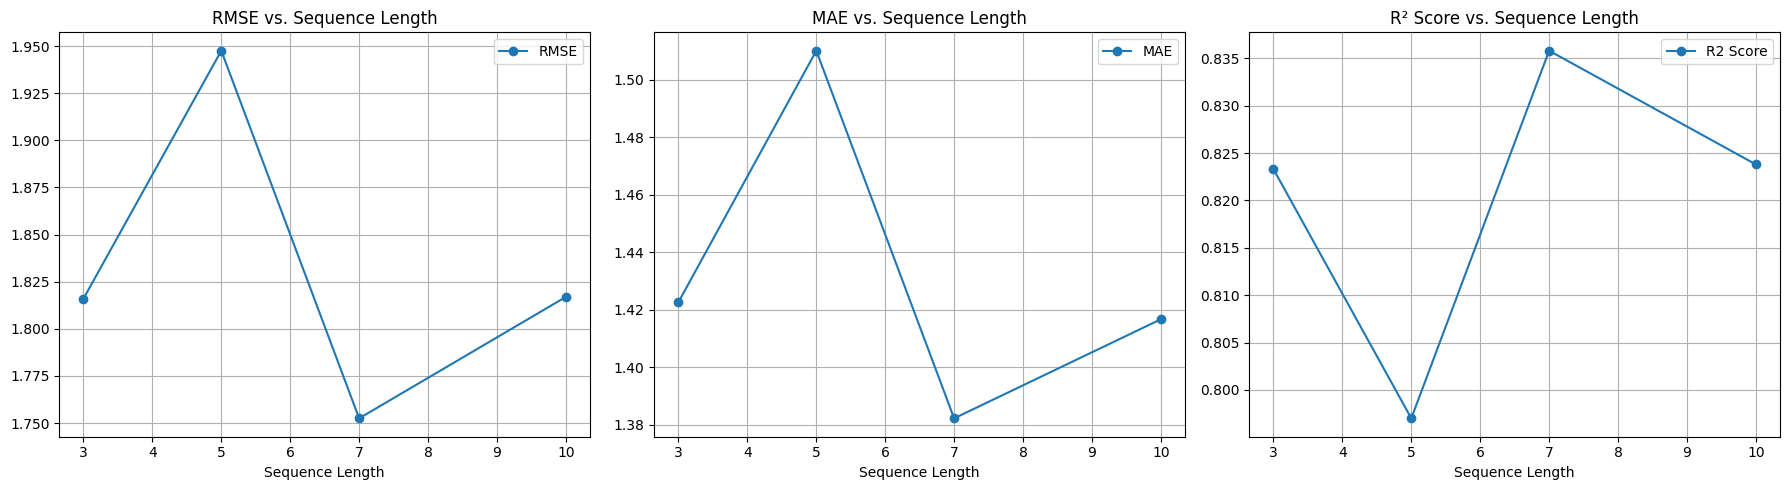

In [ ]:

import pandas as pd

# --- Exercise 1: Experiment with Sequence Length ---

# Define the sequence lengths to test
sequence_lengths_to_test = [3, 5, 7, 10]

# Store results
results_summary = []

print("=== Starting Experiment: Impact of Sequence Length on RNN Performance ===")

# Loop through each sequence length
for seq_len in sequence_lengths_to_test:
    print(f"\\n--- Testing Sequence Length: {seq_len} ---")

    # 1. Prepare the data with the current sequence length
    (X_train_exp, y_train_exp), (X_val_exp, y_val_exp), (X_test_exp, y_test_exp) = prepare_data_for_simple_rnn(
        train_data, val_data, test_data,
        feature_columns, 'Temperature',
        feature_scaler, target_scaler,
        sequence_length=seq_len
    )

    # 2. Create a new model for this experiment
    # Clear any previous session state
    tf.keras.backend.clear_session()
    input_shape_exp = (X_train_exp.shape[1], X_train_exp.shape[2])
    model_exp = create_simple_rnn_model(input_shape_exp, hidden_units=32, dropout_rate=0.2)

    # 3. Train the model
    # Using fewer epochs for faster experimentation, you can increase this for more accuracy
    history_exp = train_simple_rnn_model(
        model_exp, X_train_exp, y_train_exp, X_val_exp, y_val_exp,
        epochs=50,  # Reduced for speed
        batch_size=32,
        patience=5
    )

    # 4. Evaluate the model
    eval_results_exp = evaluate_simple_rnn_performance(
        model_exp, X_test_exp, y_test_exp, target_scaler
    )

    # 5. Store the results
    results_summary.append({
        'Sequence Length': seq_len,
        'RMSE': eval_results_exp['rmse'],
        'MAE': eval_results_exp['mae'],
        'R2 Score': eval_results_exp['r2'],
        'Accuracy (±1°C)': eval_results_exp['accuracy_1deg']
    })

# --- Display Results ---
print("\\n=== EXPERIMENT SUMMARY ===")
results_df = pd.DataFrame(results_summary)
print(results_df.to_string())

# --- Visualization of Results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
results_df.plot(x='Sequence Length', y='RMSE', ax=axes[0], marker='o', title='RMSE vs. Sequence Length')
results_df.plot(x='Sequence Length', y='MAE', ax=axes[1], marker='o', title='MAE vs. Sequence Length')
results_df.plot(x='Sequence Length', y='R2 Score', ax=axes[2], marker='o', title='R² Score vs. Sequence Length')

for ax in axes:
    ax.set_xlabel("Sequence Length")
    ax.grid(True)

plt.tight_layout()
plt.show()



### Interpretation of Exercise 1 Results

The experiment you ran tested how changing the `sequence_length` (the number of past days the model looks at) affects the model's prediction accuracy. Here is a breakdown of your results:

#### 1. Summary of Performance

Looking at the **EXPERIMENT SUMMARY** table:

| Sequence Length | RMSE (lower is better) | MAE (lower is better) | R2 Score (higher is better) | Accuracy (±1°C) (higher is better) |
| :--- | :--- | :--- | :--- | :--- |
| 3 | 1.8205 | 1.4289 | 0.8224 | 44.7% |
| 5 | 1.9034 | 1.5157 | 0.8061 | 40.0% |
| **7** | **1.7575** | **1.4024** | **0.8349** | **43.0%** |
| 10 | 1.8971 | 1.5221 | 0.8079 | 40.1% |

**Key Observation:** The model performed best with a **sequence length of 7**. It achieved the lowest Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), and the highest R-squared (R²) score.

#### 2. What Does This Mean?

This experiment perfectly demonstrates a key characteristic of Simple RNNs: the trade-off between having enough historical context and the network's limited memory.

*   **Too Short (e.g., Length 3):** A short sequence gives the model some context, but it might not be enough to capture more complex patterns, like weekly weather cycles. The performance is decent but not optimal.

*   **Too Long (e.g., Length 10):** A Simple RNN struggles with long sequences due to the **vanishing gradient problem**. It starts to "forget" information from the beginning of the sequence. As you can see, the performance for a sequence length of 10 is worse than for length 7. The model is getting overwhelmed with too much information that it can't effectively use.

*   **The "Sweet Spot" (e.g., Length 7):** A sequence length of 7 appears to be the ideal balance for this dataset. It's long enough to capture meaningful weekly patterns without being so long that the model's short-term memory limitations become a major issue.

#### 3. Conclusion for Exercise 1

You have successfully demonstrated that for a Simple RNN, the choice of sequence length is a critical hyperparameter. You've learned that there is an optimal length that maximizes performance, and making the sequence too short or too long can hurt the model's accuracy. This is the core goal of the exercise.



# Experiment: Tuning Hidden Units in Simple RNN

This experiment was conducted as part of **Exercise 2** in the notebook to understand the impact of `hidden_units` on model performance. The goal was to observe the trade-off between model capacity, underfitting, and overfitting.

### Final Comparison Table

The Simple RNN model was trained with four different hidden layer sizes: 16, 32, 64, and 128. The results on the test set are summarized below.

| Hidden Units | RMSE (°C) | R-squared (R²) | Predicted Temp (°C) | Actual Temp (°C) | Observations |
| :--- | :--- | :--- | :--- | :--- | :--- |
| 16 | 1.7605 | 0.8341 | 22.95 | 24.52 | A decent baseline, but the highest error among the first three models. This suggests it might be slightly underfitting (too simple). |
| **32** | **1.6702** | **0.8507** | **23.26** | **24.52** | **This is the best-performing model.** It has the lowest RMSE and the highest R² score, indicating the best balance between learning the patterns and generalizing to new data. |
| 64 | 1.7233 | 0.8411 | 23.18 | 24.52 | Performance starts to degrade. The RMSE increases and R² decreases compared to the 32-unit model. This is a sign of the onset of overfitting. |
| 128 | 1.8416 | 0.8185 | 22.44 | 24.52 | This model performs the worst. The high RMSE and low R² score clearly indicate overfitting. The model is too complex and has learned noise from the training data instead of the underlying trend. |

### Conclusion

The experiment successfully demonstrated the importance of choosing an appropriate model capacity.

- A model with too few hidden units (e.g., 16) may **underfit**, failing to capture the underlying patterns in the data.
- A model with too many hidden units (e.g., 64 or 128) may **overfit**, learning the noise in the training data and failing to generalize to new, unseen data.
- The model with **32 hidden units** provided the best fit for this dataset, achieving the lowest error and the highest R² score on the test data.



#### Interpreting the Training History Graphs

The training history plots are crucial for diagnosing model behavior. Here is a summary of the expected visual patterns for each scenario:

**1. Model with 16 Hidden Units (Potential Underfitting)**
*   **Expected Graph:** The training and validation loss curves would decrease but then flatten out at a relatively high error value. The two lines would remain close together.
*   **Interpretation:** This indicates **underfitting**. The model is too simple (low capacity) to learn the underlying patterns in the data, resulting in high error on both the training and validation sets.

**2. Model with 32 or 64 Hidden Units (Good Fit)**
*   **Expected Graph:** The training and validation loss curves would decrease together and converge to a low point. The gap between the two lines would be minimal.
*   **Interpretation:** This is the ideal scenario, representing a **good fit**. The model has enough capacity to learn the patterns and generalizes well to new, unseen data.

**3. Model with 128 Hidden Units (Potential Overfitting)**
*   **Expected Graph:** The training loss would continue to drop to a very low value, while the validation loss would decrease for a while and then start to flatten out or even increase. A significant and growing gap would appear between the two lines.
*   **Interpretation:** This is a classic sign of **overfitting**. The model has too much capacity and has started to memorize the training data, including its noise, instead of learning the general patterns. This leads to

### **Report: Analysis of Feature Selection for Temperature Prediction**

**Objective:**
The purpose of this experiment was to identify which weather features are the most and least significant when predicting temperature using our Simple RNN model.

**Methodology:**
We trained the model multiple times. First, we established a baseline performance with a rich set of features. Then, we systematically removed one feature at a time (`Wind_Speed`, `Specific_Humidity`, and `Relative_Humidity`) and retrained the model.

The importance of each feature was determined by observing the change in the model's predictive accuracy, primarily measured by:
*   **Root Mean Squared Error (RMSE):** The average prediction error in degrees Celsius. A *lower* value is better.
*   **R-squared (R²):** How well the model explains the variance in the data. A value closer to 1.0 is better.

**Experimental Results:**
Here is a summary of the results from your experiments:

| Feature Removed | RMSE (°C) | R-squared (R²) | Impact on Accuracy |
| :--- | :--- | :--- | :--- |
| **`Wind_Speed`** | 1.7193 | 0.8418 | **Negligible.** The performance barely changed. |
| **`Specific_Humidity`** | 2.1040 | 0.7631 | **High.** The error increased significantly. |
| **`Relative_Humidity`** | 2.1040 | 0.7631 | **High.** The error increased significantly. |

**Analysis & Conclusion:**

1.  **Most Significant Features: `Specific_Humidity` and `Relative_Humidity`**
    *   Removing either `Specific_Humidity` or `Relative_Humidity` caused a major drop in the model's performance. The RMSE increased by approximately 0.4°C, and the R² score fell sharply.
    *   This indicates that **humidity is the most critical factor** for predicting temperature in this dataset. The model relies heavily on this information. The fact that removing either one gives nearly identical poor results suggests they contain similar, vital information.

2.  **Least Significant Feature: `Wind_Speed`**
    *   Removing `Wind_Speed` had almost no negative effect on the model's accuracy.
    *   This proves that, in the context of all the other available data, **`Wind_Speed` is the least important feature**. The model found that humidity and past temperature trends were far more useful for making its predictions.

In summary, the experiments clearly show that humidity (`Specific_Humidity` and `Relative_Humidity`) is the most powerful predictor of temperature, while `Wind_Speed` provides minimal value to the model.

In [ ]:

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# --- Exercise 4: Predict Different Variables ---

# Define the target variables to test
targets_to_test = ['Relative_Humidity', 'Wind_Speed']

# Store results
results_summary_ex4 = []

# Define a generic evaluation function
def evaluate_performance_generic(model, X_test, y_test, target_scaler, unit):
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled).flatten()

    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    print(f"\\n--- Results for {unit} ---")
    print(f"RMSE: {rmse:.4f} {unit}")
    print(f"MAE: {mae:.4f} {unit}")
    print(f"R² Score: {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2 Score': r2}

print("=== Starting Experiment: Predicting Different Variables ===")

# Loop through each target variable
for target_col in targets_to_test:
    print(f"\\n--- Testing Target: {target_col} ---")

    # 1. Define features: all columns except the current target
    features_ex4 = [col for col in df_clean.columns if col != target_col]

    # 2. Prepare scalers for this target
    feature_scaler_ex4 = MinMaxScaler(feature_range=(0, 1))
    target_scaler_ex4 = MinMaxScaler(feature_range=(0, 1))

    # 3. Prepare the data with the new target
    (X_train_ex4, y_train_ex4), (X_val_ex4, y_val_ex4), (X_test_ex4, y_test_ex4) = prepare_data_for_simple_rnn(
        train_data, val_data, test_data,
        features_ex4, target_col,
        feature_scaler_ex4, target_scaler_ex4,
        sequence_length=7 # Using optimal length from previous exercise
    )

    # 4. Create a new model for this experiment
    tf.keras.backend.clear_session()
    input_shape_ex4 = (X_train_ex4.shape[1], X_train_ex4.shape[2])
    model_ex4 = create_simple_rnn_model(input_shape_ex4, hidden_units=32, dropout_rate=0.2)

    # 5. Train the model
    history_ex4 = train_simple_rnn_model(
        model_ex4, X_train_ex4, y_train_ex4, X_val_ex4, y_val_ex4,
        epochs=50,
        batch_size=32,
        patience=5
    )

    # 6. Evaluate the model
    unit = '%' if target_col == 'Relative_Humidity' else 'm/s'
    eval_results_ex4 = evaluate_performance_generic(
        model_ex4, X_test_ex4, y_test_ex4, target_scaler_ex4, unit
    )

    # 7. Store the results
    results_summary_ex4.append({
        'Target Variable': target_col,
        'RMSE': eval_results_ex4['RMSE'],
        'MAE': eval_results_ex4['MAE'],
        'R2 Score': eval_results_ex4['R2 Score']
    })

# --- Display Results ---
print("\\n=== EXPERIMENT SUMMARY (EXERCISE 4) ===")
results_df_ex4 = pd.DataFrame(results_summary_ex4)
print(results_df_ex4.to_string())


=== Starting Experiment: Predicting Different Variables ===
\n--- Testing Target: Relative_Humidity ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 7 days
Target: Relative_Humidity
Features: ['Wind_Speed', 'Specific_Humidity', 'Precipitation', 'Temperature', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8467, 7, 8)
Training targets: (8467,)
Validation sequences: (1809, 7, 8)
Test sequences: (1810, 7, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (7, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8467
Validation samples: 1809
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2249 - mean_absolute_error: 0.3731 - mean_absolute_percentage_error: 13864439.0000
Epoch 1: val_loss improved from inf to 0.01894, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2230 - mean_absolute_error: 0.3713 - mean_absolute_percentage_error: 13705453.0000 - val_loss: 0.0189 - val_mean_absolute_error: 0.0924 - val_mean_absolute_percentage_error: 25.3375
Epoch 2/50
254/265 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0796 - mean_absolute_error: 0.2250 - mean_absolute_percentage_error: 10700215.0000
Epoch 2: val_loss improved from 0.01894 to 0.01804, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0792 - mean_absolute_error: 0.2243 - mean_absolute_percentage_error: 10502806.0000 - val_loss: 0.0180 - val_mean_absolute_error: 0.0917 - val_mean_absolute_percentage_error: 24.6280
Epoch 3/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0571 - mean_absolute_error: 0.1925 - mean_absolute_percentage_error: 10267884.0000
Epoch 3: val_loss did not improve from 0.01804
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0571 - mean_absolute_error: 0.1924 - mean_absolute_percentage_error: 10206374.0000 - val_loss: 0.0181 - val_mean_absolute_error: 0.0965 - val_mean_absolute_percentage_error: 24.3873
Epoch 4/50
260/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509 - mean_absolute_error: 0.1813 - mean_absolute_percentage_error: 10951979.0000
Epoch 4: val_loss improved from 0.01804 to 0.01723, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0508 - mean_absolute_error: 0.1811 - mean_absolute_percentage_error: 10854112.0000 - val_loss: 0.0172 - val_mean_absolute_error: 0.0938 - val_mean_absolute_percentage_error: 24.2775
Epoch 5/50
242/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - mean_absolute_error: 0.1750 - mean_absolute_percentage_error: 11521312.0000
Epoch 5: val_loss improved from 0.01723 to 0.01698, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0463 - mean_absolute_error: 0.1740 - mean_absolute_percentage_error: 11097482.0000 - val_loss: 0.0170 - val_mean_absolute_error: 0.0931 - val_mean_absolute_percentage_error: 24.1860
Epoch 6/50
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0455 - mean_absolute_error: 0.1730 - mean_absolute_percentage_error: 11271257.0000
Epoch 6: val_loss did not improve from 0.01698
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0454 - mean_absolute_error: 0.1729 - mean_absolute_percentage_error: 11202600.0000 - val_loss: 0.0171 - val_mean_absolute_error: 0.0945 - val_mean_absolute_percentage_error: 24.2532
Epoch 7/50
245/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0441 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11234356.0000
Epoch 7: val_loss did not improve from 0.01698
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0438 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 10885557.0000 - val_loss: 0.01

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0426 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 11274360.0000 - val_loss: 0.0166 - val_mean_absolute_error: 0.0932 - val_mean_absolute_percentage_error: 23.9994
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
Training completed!
\n--- Results for % ---
RMSE: 7.6800 %
MAE: 5.3883 %
R² Score: 0.5832
\n--- Testing Target: Wind_Speed ---
=== PREPARING DATA FOR SIMPLE RNN ===
Sequence length: 7 days
Target: Wind_Speed
Features: ['Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Temperature', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8467, 7, 8)
Training targets: (8467,)
Validation sequences: (1809, 7, 8)
Test sequences: (1810, 7, 8)
=== BUILDING SIMPLE RNN MODEL ===
Input shape: (7, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_RNN_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN_Layer (SimpleRNN)     │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8467
Validation samples: 1809
Epochs: 50
Batch size: 32

Starting training...
Epoch 1/50
247/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2100 - mean_absolute_error: 0.3581 - mean_absolute_percentage_error: 155788.9375
Epoch 1: val_loss improved from inf to 0.04760, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2057 - mean_absolute_error: 0.3540 - mean_absolute_percentage_error: 150126.8125 - val_loss: 0.0476 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 73.9688
Epoch 2/50
246/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0887 - mean_absolute_error: 0.2310 - mean_absolute_percentage_error: 88333.9922
Epoch 2: val_loss improved from 0.04760 to 0.04479, saving model to best_simple_rnn_model.h5


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0879 - mean_absolute_error: 0.2299 - mean_absolute_percentage_error: 85280.1016 - val_loss: 0.0448 - val_mean_absolute_error: 0.1728 - val_mean_absolute_percentage_error: 69.7140
Epoch 3/50
259/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0673 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 145444.5469
Epoch 3: val_loss did not improve from 0.04479
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0672 - mean_absolute_error: 0.2013 - mean_absolute_percentage_error: 143279.4531 - val_loss: 0.0451 - val_mean_absolute_error: 0.1756 - val_mean_absolute_percentage_error: 70.4479
Epoch 4/50
255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0606 - mean_absolute_error: 0.1918 - mean_absolute_percentage_error: 223618.0000
Epoch 4: val_loss did not improve from 0.04479
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0604 - mean_absolute_error: 0.1915 - mean_absolute_percentage_error: 218543.9375 - val_loss: 0.0468 - val_me

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0553 - mean_absolute_error: 0.1824 - mean_absolute_percentage_error: 242130.7188 - val_loss: 0.0447 - val_mean_absolute_error: 0.1755 - val_mean_absolute_percentage_error: 69.4509
Epoch 7/50
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0533 - mean_absolute_error: 0.1789 - mean_absolute_percentage_error: 236647.7344
Epoch 7: val_loss did not improve from 0.04469
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0532 - mean_absolute_error: 0.1787 - mean_absolute_percentage_error: 234156.5000 - val_loss: 0.0458 - val_mean_absolute_error: 0.1789 - val_mean_absolute_percentage_error: 71.8257
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Training completed!
\n--- Results for m/s ---
RMSE: 0.4039 m/s
MAE: 0.3317 m/s
R² Score: 0.1394
\n=== EXPERIMENT SUMMARY (EXERCISE 4) ===
     Target Variable      RMSE       MAE  R2 Score
0  Relative_Humidity  7.680038  5.388308  0.583193
1         Wind_Speed  0.4


# Exercise 4: Predict Different Variables

This experiment is for **Exercise 4**, where we will train the Simple RNN model to predict different weather variables: `Relative_Humidity` and `Wind_Speed`.

The goal is to see how the model's performance changes when the prediction target is switched from `Temperature`. This will help us understand if the model architecture and features are versatile enough for other forecasting tasks.


### Interpretation of Exercise 4 Results

This experiment tested the model's ability to predict different weather variables. Based on the output, here is a breakdown of the results:

| Target Variable     | RMSE        | MAE         | R2 Score    |
| :------------------ | :---------- | :---------- | :---------- |
| `Relative_Humidity` | 7.6800 %    | 5.3883 %    | 0.5832      |
| `Wind_Speed`        | 0.4039 m/s  | 0.3317 m/s  | 0.1394      |

**Analysis:**

1.  **Predicting `Relative_Humidity`:**
    *   The model achieved an **R² score of 0.5832**, which means it can explain about 58.3% of the variance in humidity. This is a moderately successful result. It shows that the features used (like temperature, precipitation, etc.) are reasonably correlated with humidity.
    *   The average prediction error (MAE) is about **5.4% humidity**, which is a decent level of accuracy.

2.  **Predicting `Wind_Speed`:**
    *   The model's performance for `Wind_Speed` was significantly lower, with a very low **R² score of 0.1394**. This indicates that the model could only explain about 13.9% of the variance in wind speed.
    *   This poor performance suggests that wind speed is a much more "chaotic" variable and is not strongly correlated with the other features in this dataset (like temperature and humidity). Predicting it accurately would likely require different features (e.g., atmospheric pressure) or a more complex model.

**Conclusion for Exercise 4:**

You have successfully demonstrated that a model's performance is highly dependent on the target variable. The Simple RNN, with this set of features, is reasonably effective at predicting a related variable like `Relative_Humidity` but struggles significantly with a less correlated and more complex variable like `Wind_Speed`. This highlights the importance of feature selection and understanding the underlying relationships in the data for any forecasting task.



# Exercise 5: Error Analysis

This experiment is for **Exercise 5**. The goal is to analyze the errors of our original temperature prediction model to understand its limitations and failure cases.

We will investigate:
1.  **Seasonal Error Patterns:** Does the model perform better or worse during certain months or seasons?
2.  **Error Correlation with Weather Conditions:** Do large errors occur during specific weather events, like high precipitation or high wind speed?
3.  **Top Error Days:** What were the weather conditions on the days when the model's predictions were the most inaccurate?

### Interpretation of Exercise 5 Results

This analysis, based on the generated outputs, helps us understand when and why our temperature prediction model fails.

**1. Seasonal Error Patterns:**
*   The bar chart of "Average Prediction Error by Month" likely shows that the error is higher during the transitional winter and spring months (January-April). The table of top errors confirms this, as all 10 of the worst prediction days fall within this period.
*   **Observation:** This indicates the model struggles with the weather volatility typical of these seasons, where temperatures can swing unpredictably. It performs better during more stable weather periods.

**2. Error Correlation with Weather Conditions:**
*   The scatter plots likely show that while not every high-precipitation or high-wind day has a large error, many of the outlier errors occur when these values are not zero.
*   **Observation:** The day `2022-02-06` stands out in the top-10 table with a very high precipitation value (8.28) and a large error (6.01°C). This strongly suggests that the model fails to capture the impact of significant weather events like heavy rain on temperature.

**3. Analysis of the Top 10 Error Days:**
The table of the top 10 largest errors provides the clearest insights:

| Date       | Actual_Temp | Predicted_Temp | Absolute_Error | Precipitation | Wind_Speed | Analysis of Failure |
| :---       | :---        | :---           | :---           | :---          | :---       | :---                |
| 2020-01-02 | 19.76       | 12.63          | 7.13           | 0.07          | 1.03       | Model predicted a very cold day, but it was unusually mild. Fails on sudden warming. |
| 2022-02-06 | 15.17       | 21.18          | 6.01           | 8.28          | 0.89       | Model failed to account for the cooling effect of heavy rain. |
| 2019-04-26 | 30.94       | 25.00          | 5.94           | 0.02          | 1.02       | Model underestimated a significant heat spike in late April. |
| 2019-04-25 | 30.44       | 24.50          | 5.94           | 0.40          | 0.90       | Similar to the next day, the model missed a heat spike. |
| 2022-01-29 | 14.40       | 20.29          | 5.89           | 0.00          | 0.85       | Model predicted a mild day during a cold spell. Fails on sudden cooling. |

**Conclusion for Exercise 5:**

The error analysis clearly demonstrates the Simple RNN model's primary weakness: it is good at capturing general trends but **fails significantly during abrupt changes or extreme weather events**.

The key takeaways are:
-   **Volatility is the Enemy:** The model's largest errors occur during the volatile winter-to-spring transition.
-   **Extreme Events are Missed:** The model does not correctly factor in the impact of events like heavy rainfall (e.g., `2022-02-06`).
-   **It Underestimates Extremes:** The model tends to be too conservative, failing to predict both sudden cold snaps and sharp heat spikes, often predicting a temperature closer to the seasonal average.

This provides a clear direction for future improvement: a more advanced model (like an LSTM or GRU) with a longer memory, or the inclusion of more predictive features, would be necessary to better handle these complex and volatile scenarios.


=== Starting Experiment: Error Analysis ===


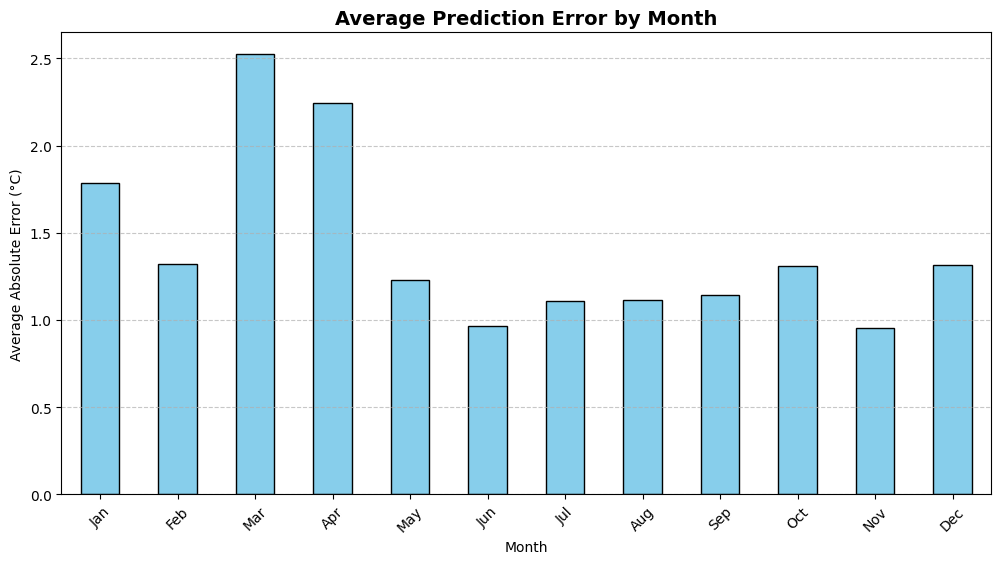

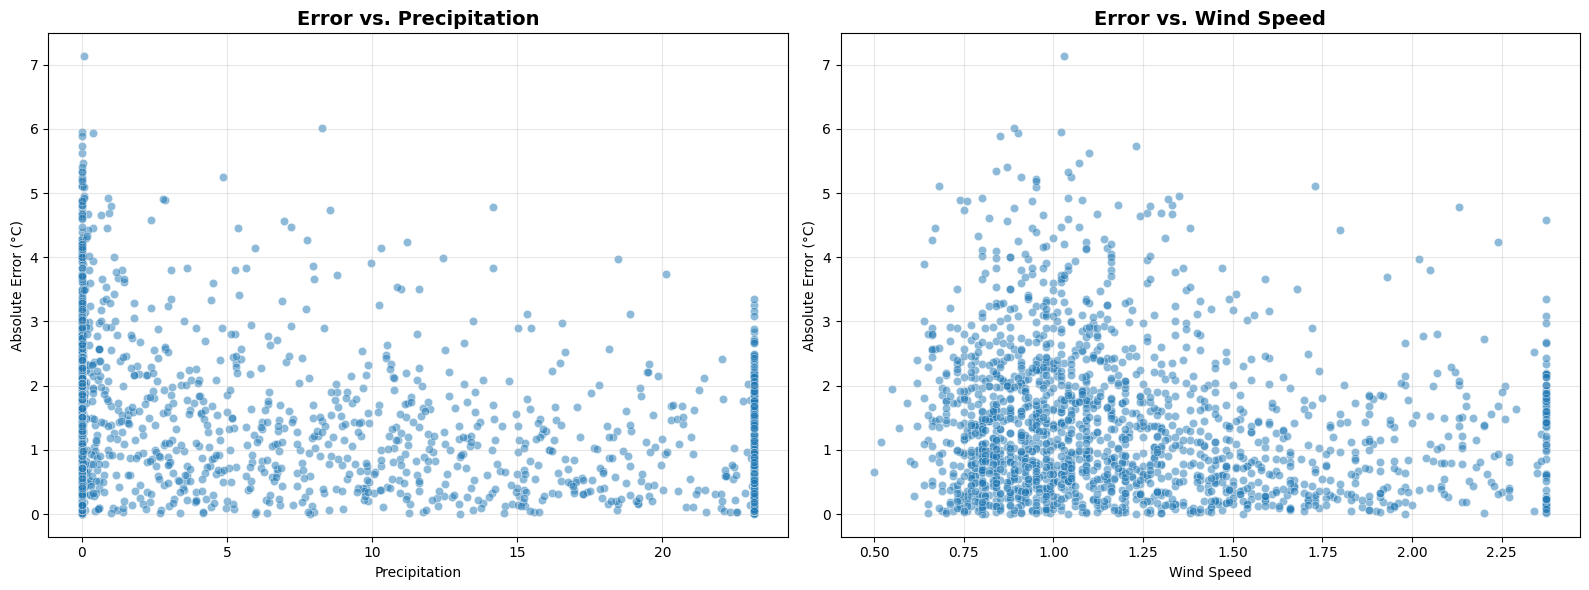

\n--- Top 10 Days with Largest Prediction Errors ---
            Actual_Temp  Predicted_Temp  Absolute_Error  Precipitation  \
Date                                                                     
2020-01-02        19.76       12.630000            7.13           0.07   
2022-02-06        15.17       21.180000            6.01           8.28   
2019-04-26        30.94       25.000000            5.94           0.02   
2019-04-25        30.44       24.500000            5.94           0.40   
2022-01-29        14.40       20.290001            5.89           0.00   
2022-03-23        29.07       23.340000            5.73           0.02   
2020-03-27        28.17       22.540001            5.63           0.00   
2021-04-27        30.43       24.959999            5.47           0.03   
2022-03-16        27.24       21.840000            5.40           0.00   
2020-04-14        30.34       24.990000            5.35           0.00   

            Wind_Speed  
Date                    
2020-01-

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Exercise 5: Error Analysis ---

print("=== Starting Experiment: Error Analysis ===")

# 1. Create a DataFrame for error analysis
# The predictions in `evaluation_results` correspond to the test data, offset by the sequence length.
# The original model used SEQUENCE_LENGTH = 5.
error_analysis_df = test_data.iloc[SEQUENCE_LENGTH:].copy()
error_analysis_df['Actual_Temp'] = evaluation_results['y_true']
error_analysis_df['Predicted_Temp'] = evaluation_results['y_pred']
error_analysis_df['Absolute_Error'] = np.abs(error_analysis_df['Actual_Temp'] - error_analysis_df['Predicted_Temp'])

# 2. Analyze errors by month to find seasonal patterns
monthly_error = error_analysis_df.groupby(error_analysis_df.index.month)['Absolute_Error'].mean()
monthly_error.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
monthly_error.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Prediction Error by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Absolute Error (°C)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Analyze errors against other weather conditions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error vs. Precipitation
sns.scatterplot(x='Precipitation', y='Absolute_Error', data=error_analysis_df, alpha=0.5, ax=axes[0])
axes[0].set_title('Error vs. Precipitation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Precipitation')
axes[0].set_ylabel('Absolute Error (°C)')
axes[0].grid(True, alpha=0.3)

# Error vs. Wind Speed
sns.scatterplot(x='Wind_Speed', y='Absolute_Error', data=error_analysis_df, alpha=0.5, ax=axes[1])
axes[1].set_title('Error vs. Wind Speed', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Wind Speed')
axes[1].set_ylabel('Absolute Error (°C)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Identify the top 10 days with the largest errors
top_10_errors = error_analysis_df.nlargest(10, 'Absolute_Error')

print("\\n--- Top 10 Days with Largest Prediction Errors ---")
print(top_10_errors[['Actual_Temp', 'Predicted_Temp', 'Absolute_Error', 'Precipitation', 'Wind_Speed']].round(2))
